## Final Project Submission

Please fill out:
* Student name: **Dennis Trimarchi**
* Student pace: **full time**
* Scheduled project review date/time: **Not yet scheduled**
* Instructor name: **Rafael Cassaro**
* Blog post URL: **Not yet created**

This file: **Student_3_EDA_Model.jpynb**

## Modeling


### Import a bunch of libraries

There are a bunch of libraries that are used in this project. They are imported and aliased below.

In [1]:
#Datarames and Computation
import numpy as np
import pandas as pd

#Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#STATSMODELS

#statistical analysis & regression
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

#SCIKIT LEARN

#metrics
from sklearn.metrics import mean_squared_error

#linear regression
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

#label encoding
#from sklearn.preprocessing import LabelEncoder
#lb_make = LabelEncoder()

#create dummy variables
#from sklearn.preprocessing import LabelBinarizer
#lb_bin = LabelBinarizer()

#recursive feature elimination
from sklearn.feature_selection import RFE

#train test split
from sklearn.model_selection import train_test_split

#k-fold cross validation
from sklearn.model_selection import cross_val_score

#PICKLE for saving objects
import pickle

#### Read in DataFrame from pickle file

In [2]:
with open('data.pickle','rb') as f:
    data = pickle.load(f)
    
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zip_981,has_basement
count,2.096300e+04,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000,20963.000000
mean,5.154048e+05,3.355102,2.108858,2032.599389,10750.234270,1.488360,0.004675,3.411153,7.614607,1749.281925,1970.785384,1972.678338,98078.731384,47.560797,-122.217000,1962.964080,9979.023184,0.423365,0.383247
std,2.830298e+05,0.879990,0.728166,834.998842,13638.141655,0.539631,0.068215,0.649884,1.119503,769.590305,29.371643,28.971475,53.656112,0.138196,0.138392,662.339591,11795.111734,0.494104,0.486189
min,7.800000e+04,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,1900.000000,98001.000000,47.155900,-122.512000,460.000000,651.000000,0.000000,0.000000
25%,3.200000e+05,3.000000,1.500000,1410.000000,5000.000000,1.000000,0.000000,3.000000,7.000000,1180.000000,1951.000000,1954.000000,98033.000000,47.472750,-122.330000,1480.000000,5054.000000,0.000000,0.000000
50%,4.470000e+05,3.000000,2.000000,1890.000000,7500.000000,1.500000,0.000000,3.000000,7.000000,1540.000000,1974.000000,1977.000000,98070.000000,47.571900,-122.235000,1820.000000,7536.000000,0.000000,0.000000
75%,6.300000e+05,4.000000,2.500000,2500.000000,10275.000000,2.000000,0.000000,4.000000,8.000000,2160.000000,1996.000000,1998.000000,98118.000000,47.678850,-122.129000,2330.000000,9870.000000,1.000000,1.000000
max,1.990000e+06,7.000000,5.000000,5990.000000,149410.000000,3.500000,1.000000,5.000000,13.000000,5990.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.000000,149410.000000,1.000000,1.000000


### Explore data a bit more
Correlations and Heatmap

In [3]:
correlations = data.corr()
correlations['price'].sort_values(ascending=False)

price            1.000000
grade            0.674132
sqft_living      0.671363
sqft_living15    0.598063
sqft_above       0.572003
bathrooms        0.488452
lat              0.373699
bedrooms         0.321556
floors           0.274029
has_basement     0.178310
waterfront       0.145956
sqft_lot         0.120031
sqft_lot15       0.111745
yr_renovated     0.094559
yr_built         0.053003
condition        0.041814
long             0.027491
zip_981          0.002487
zipcode         -0.040772
Name: price, dtype: float64

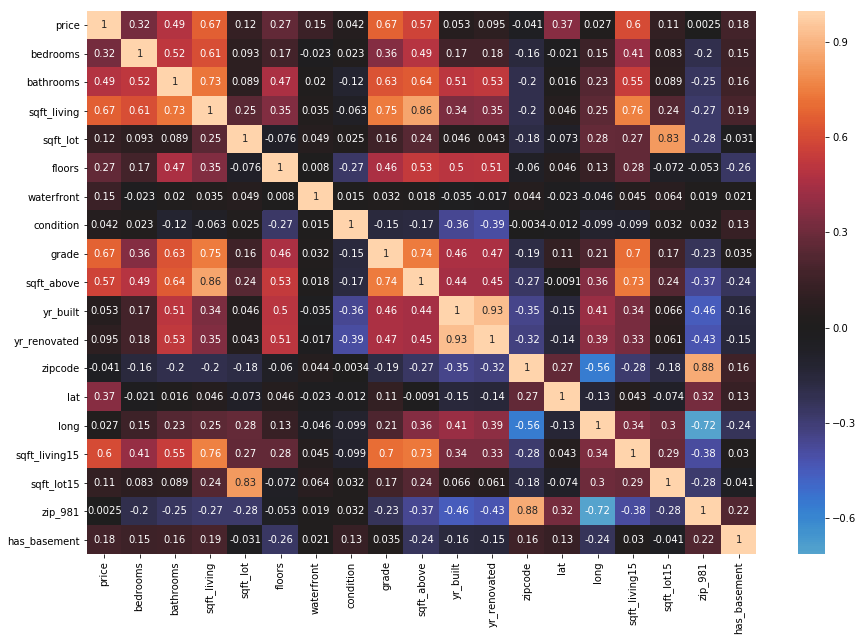

In [4]:
plt.figure(figsize=(15,10))
sns.heatmap(correlations, center=0, annot=True)

#### Analysis of Heatmap

- All of that work updating yr_renovated to be more representative and it's still poorly correlated to price.
- Zip_981 is also poorly correlated. 
- There is some nasty collinearity going on between several of my features: 
  - sqft_living
  - sqft_living15
  - sqft_above
  - bedrooms
  - bathrooms
  - grade
- Will want to drop all features with < .10 correlation
- I would like to utilize lat and long in some way to create a new variable. Make a distance from X point variable.

#### Make a new distance from Bellvue, WA variable

I ran the below code which includes a function and then some nested for loops to see if there exist a location that has a strong correlation with price. It returned a location just northeast of Bellvue, WA. I will create a new column called "dist_from_Bellvue" which will contain the distance in miles from Bellvue, WA.

In [5]:
#Function to calculate the distance between to geographical points in latitude and longitude.

import math
def distance_between(lat1, long1, lat2, long2):
    """
    Calculates the distance between two points.

    Parameters:
    lat1 = latitude of place #1
    long1 = longitude of place #1
    lat2 = latitude of place #2
    long2 = longitude of place #2

    Returns:
    distance in miles
    """
    
    radius = 3958.756  # miles

    dlat = math.radians(lat2 - lat1)
    dlong = math.radians(long2 - long1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlong / 2) * math.sin(dlong / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = radius * c
    
    return d


In [52]:
#Check a range of points on the map to find a point where correlation with price is highest

#Get min and max values for lat and long columns
min_lat = data['lat'].min()
max_lat = data['lat'].max()
min_long = data['long'].min()
max_long = data['long'].max()


max_corr = 0
best_point = (0,0)

#iterate through latitudes and longitudes to provide a point to reference against
for lat_pt in np.linspace(min_lat, max_lat, 50):
    for long_pt in np.linspace(min_long, max_long, 50):
        #make a list to contain the distances to the point from dataset locations
        dist = []
        #iterate through DataFrame locations
        for lat_data, long_data in zip(data.lat, data.long):
            #create list of distances
            dist.append(distance_between(lat_data,long_data,lat_pt,long_pt))
        
        #once the list is populated, check correlation with price
        dist_correlation = np.corrcoef(data['price'], dist)[1][0]
        dist = []
        #check if new correlation is larger and update if so
        if abs(dist_correlation) > max_corr:
            max_corr = abs(dist_correlation)
            best_point = (lat_pt,long_pt)
            

best_point
#Ran with 50 latitudes and 50 longitudes (50x50) points, which took a long time:
#Returned 47.63803469387755, -122.17, with correlation of 0.48734

(47.63316464646465, -122.16136363636363)

**This is Bellvue, WA** 

And this reult makes sense from the geography plot that I did in notebook 1. Bellvue is in the area where the dark high price dots are located. I'm going to create the new column below

In [6]:
dist = []
for lat, long in zip(data.lat, data.long):
    dist.append(distance_between(lat,long, 47.63803469387755, -122.17))
    
data['dist_from_Bellvue'] = dist

**Need to check for Normality of newly created feature**

Ran dist and scatter plots - it was skewed looking. Decided to take the log. Histogram looks nicer and it is more highly correlated with price. It's not perfect, but it's better.

In [7]:
data['log_dist_from_Bellvue'] = data['dist_from_Bellvue'].apply(lambda x: np.log(x))

log_dist_from_Bellvue


/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


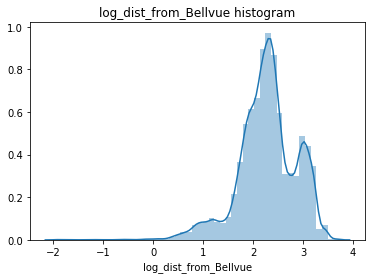

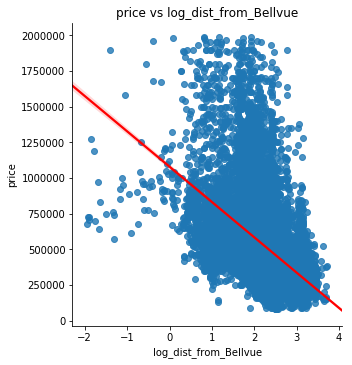

In [10]:
feature_plots('log_dist_from_Bellvue', 'price', data)

#### Check Heatmap again

price                    1.000000
grade                    0.674132
sqft_living              0.671363
sqft_living15            0.598063
sqft_above               0.572003
log_dist_from_Bellvue    0.513302
bathrooms                0.488452
dist_from_Bellvue        0.487335
lat                      0.373699
bedrooms                 0.321556
floors                   0.274029
has_basement             0.178310
waterfront               0.145956
sqft_lot                 0.120031
sqft_lot15               0.111745
yr_renovated             0.094559
yr_built                 0.053003
condition                0.041814
zipcode                  0.040772
long                     0.027491
zip_981                  0.002487
Name: price, dtype: float64


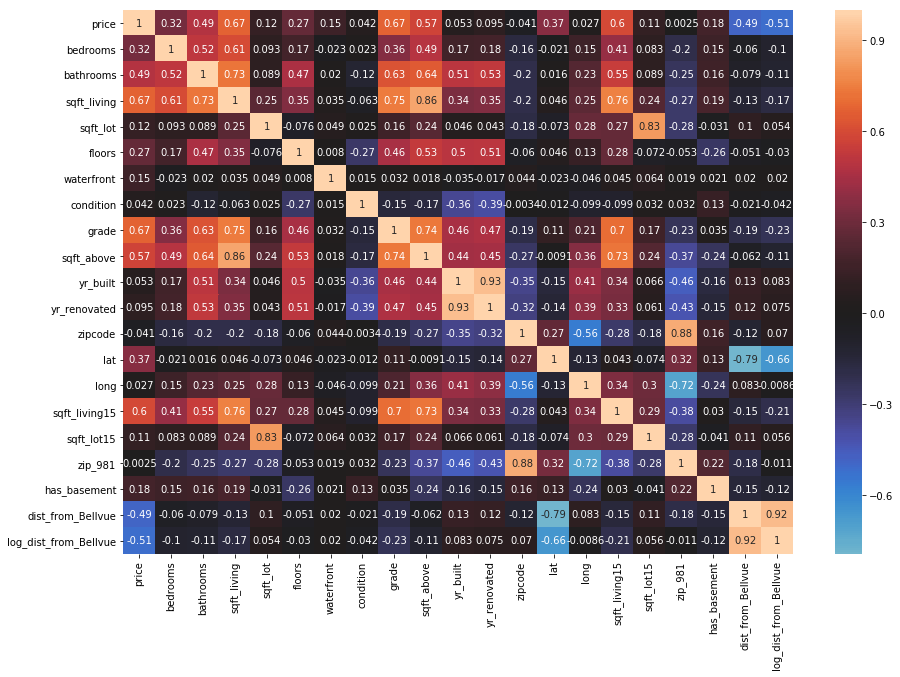

In [11]:
correlations = data.corr()
print(abs(correlations['price']).sort_values(ascending=False))
plt.figure(figsize=(15,10))
sns.heatmap(correlations, center=0, annot=True)

Dropping every column that has a correlation with Price <= 0.10, and latitude since we used it in this new feature dist_from_Bellvue.

In [29]:
X = data.drop(['condition', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'zip_981'], axis=1)

In [30]:
y = data['price']

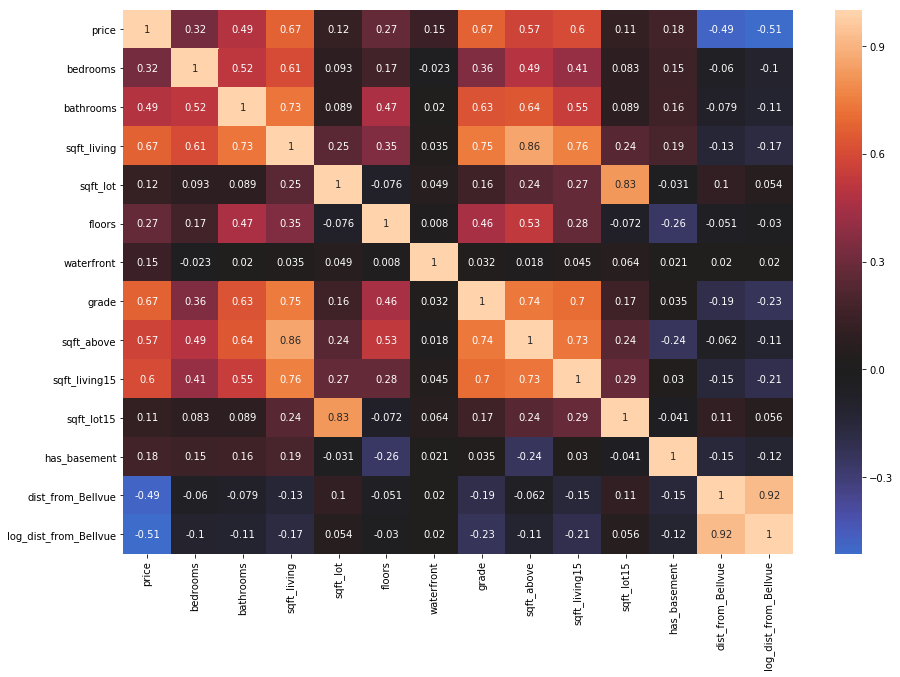

In [14]:
correlations = X.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlations, center=0, annot=True)

### Time to deal with this Collinearity Mess

**Two groups of collinear features**

**Group 1**
- Features
  - sqft_living
  - sqft_living15 XX
  - sqft_above    XX
  - bedrooms
  - bathrooms
  - grade
- Plan
  - Drop sqft_above. It is basically the same thing as sqft_living
  - Drop sqft_living15. Highly correlated with sqft_living. Not sure that it adds much.

**Group 2**
- Features
  - sqft_lot
  - sqft_lot15    XX
- Plan
  - Drop sqft_lot15 - doesn't add much. Slightly lower correlation with price.


In [15]:
X = X.drop(['sqft_living15','sqft_above','sqft_lot15'], axis=1)

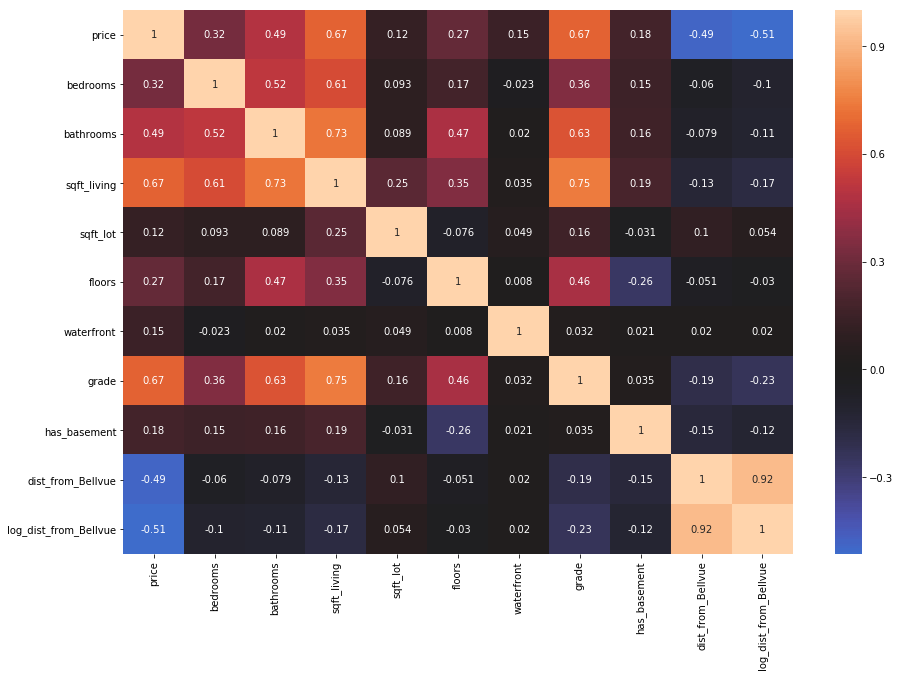

In [16]:
correlations = X.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlations, center=0, annot=True)

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = 

In [28]:
#K-FOLD Cross Validation

X_fit = X.drop(['price'],axis=1)

cv_10_results = np.mean(cross_val_score(linreg,X_ols,y,cv=10,scoring='neg_mean_squared_error'))

(-cv_10_results)**0.5

174492.8163522294

**Feature Ranking with Recursive Feature Elimination**

Shows ranked features:

1. waterfront
2. log_dist_from_Bellvue
3. grade
4. has_basement
5. bathrooms
6. bedrooms
7. dist_from_Bellvue
8. floors
9. sqft_living
10. sqft_lot

In [148]:
X.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,has_basement,dist_from_Bellvue,log_dist_from_Bellvue
0,221900.0,3,1.0,1180,5650,1.0,0,7,0,9.656240,2.267604
1,538000.0,3,2.0,2570,7242,2.0,0,7,1,8.994609,2.196625
2,180000.0,2,1.0,770,10000,1.0,0,6,0,7.496435,2.014428
3,604000.0,4,3.0,1960,5000,1.0,0,7,1,13.177219,2.578489
4,510000.0,3,2.0,1680,8080,1.0,0,8,0,6.002734,1.792215


In [32]:
X_fit = X.drop(['price'], axis=1)

selector = RFE(linreg, n_features_to_select=4)
selector = selector.fit(X_fit,y)
estimators = selector.estimator_

for col, rank in zip(X_fit.columns,selector.ranking_):
    print("{} - {}".format(rank,col))
    
print(selector.support_)
print(estimators.coef_)
print(estimators.intercept_)

3 - bedrooms
2 - bathrooms
6 - sqft_living
10 - sqft_lot
5 - floors
1 - waterfront
1 - grade
8 - sqft_above
7 - sqft_living15
9 - sqft_lot15
1 - has_basement
4 - dist_from_Bellvue
1 - log_dist_from_Bellvue
[False False False False False  True  True False False False  True False
  True]
[ 549244.12035771  146766.0045127    64314.49911558 -177355.62444251]
-225607.3059666957


In [23]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

[ 549244.12035771  146766.0045127    64314.49911558 -177355.62444251]
-225607.3059666957


In [24]:
selector.ranking_

array([3, 2, 6, 7, 5, 1, 1, 1, 4, 1])

In [27]:
X_ols = X.drop(['price','sqft_living','floors','dist_from_Bellvue','bedrooms','bathrooms'], axis=1)
X_int = sm.add_constant(X_ols)
model = sm.OLS(y,X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                     6869.
Date:                Fri, 31 May 2019   Prob (F-statistic):               0.00
Time:                        15:43:38   Log-Likelihood:            -2.8273e+05
No. Observations:               20963   AIC:                         5.655e+05
Df Residuals:                   20957   BIC:                         5.655e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -2.155e+05   1.08e+04    -19.896      0.000   -2.37e+05   -1.94e+05
sqft_lot                  0.9261      0.090     10.296      0.000       0.750       1.102
waterfront             5.415e+05   1.77e+04     30.626      0.000    5.07e+05    5.76e+05
grade                  1.447e+05   1124.166    128.720      0.000    1.42e+05    1.47e+05
has_basement           6.501e+04   2495.555     26.049      0.000    6.01e+04    6.99e+04
log_dist_from_Bellvue -1.794e+05   2132.974    -84.085      0.000   -1.84e+05   -1.75e+05
==============================================================================
Omnibus:                     6250.931   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26660.643
Skew:                           1.413   Prob(JB):                         0.00
Kurtosis:                       7.747   Cond. No.                     2.55e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.55e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

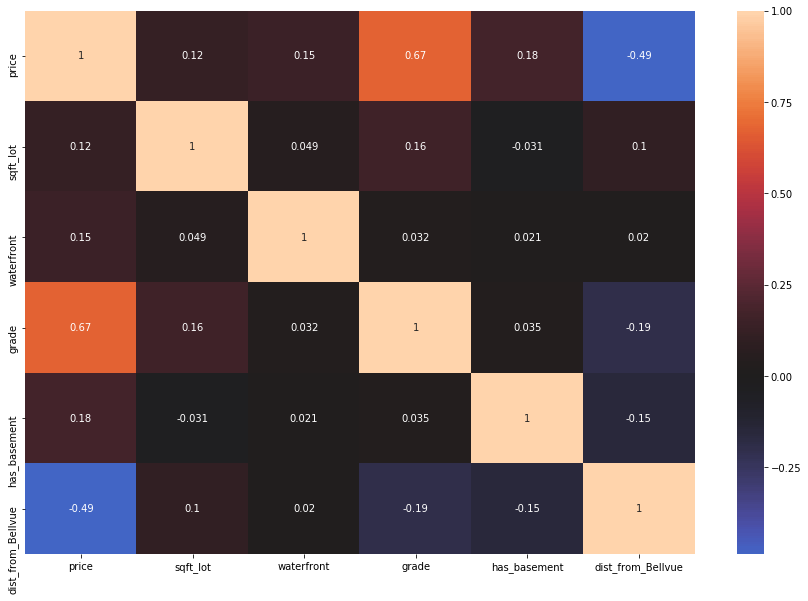

In [26]:
X_corr = X.drop(['sqft_living','floors','bedrooms','bathrooms','log_dist_from_Bellvue'], axis=1)
correlations = X_corr.corr()
plt.figure(figsize=(15,10))
sns.heatmap(correlations, center=0, annot=True)

Noticed that I need to slice some data a bit more.

bedrooms


/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


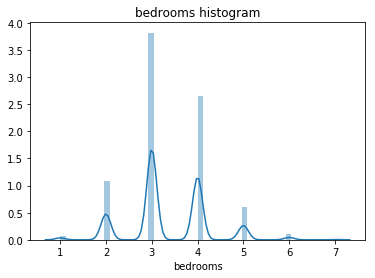

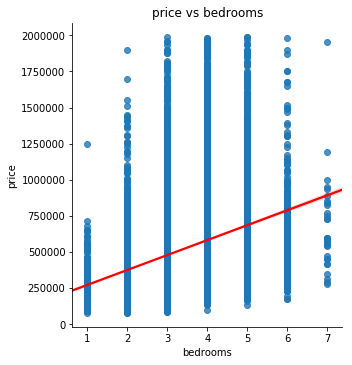

bathrooms


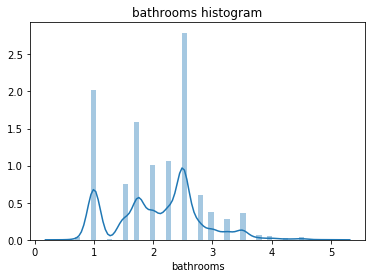

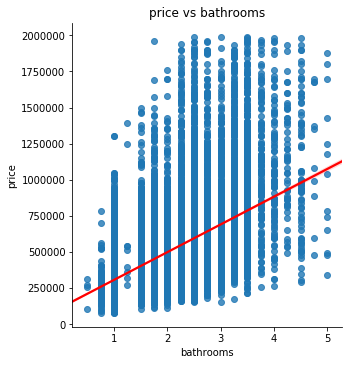

sqft_living


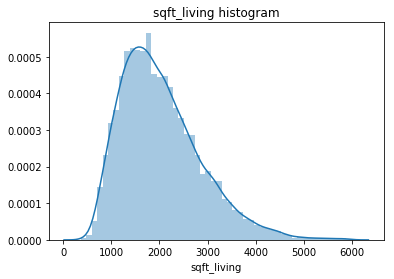

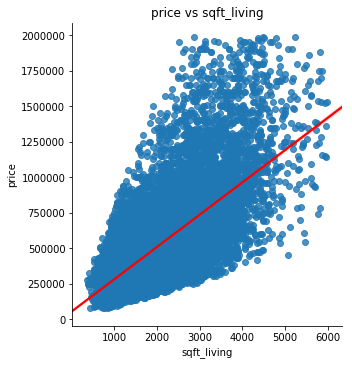

sqft_lot


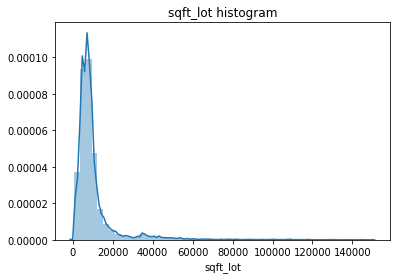

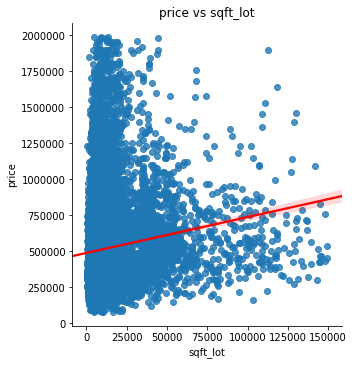

floors


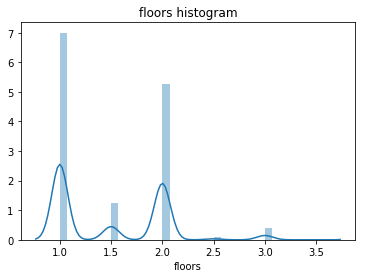

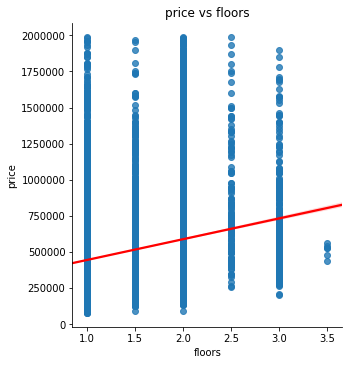

grade


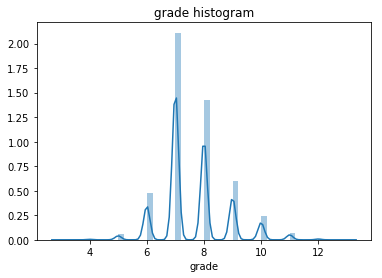

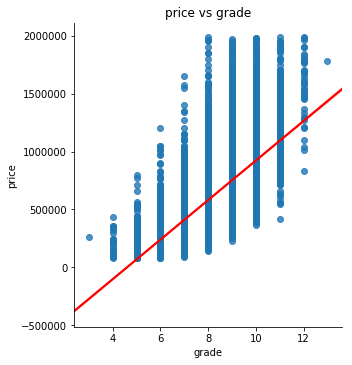

sqft_above


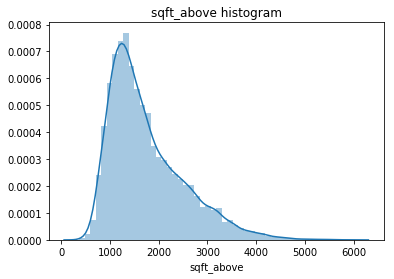

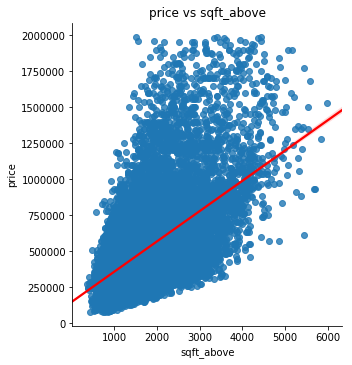

has_basement


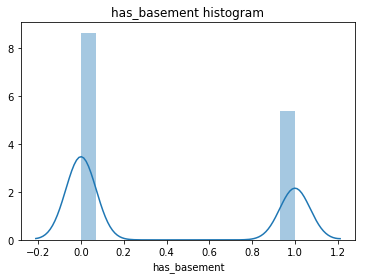

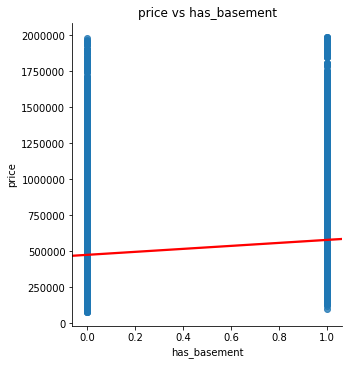

dist_from_Bellvue


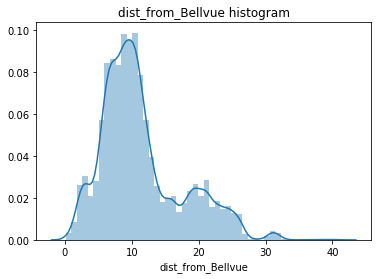

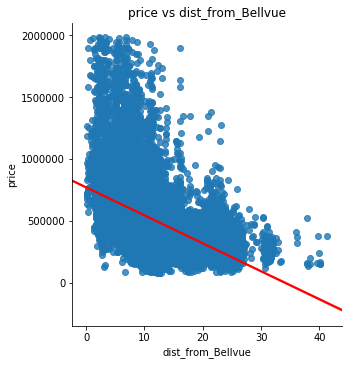

In [69]:
#ist of feature names to run histograms and scatterplots on to check for outliers
feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                 'grade', 'sqft_above','has_basement', 'dist_from_Bellvue']

#plot the features in a histogram and scatter w/ target
for feature in feature_names:
    feature_plots(feature, 'price', data)

In [74]:
smaller_df = data

smaller_df['log_dist_from_Bellvue'] = smaller_df['dist_from_Bellvue'].apply(lambda x: np.log(x))

log_dist_from_Bellvue


/Users/dennistrimarchi/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


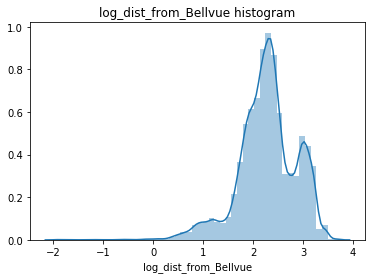

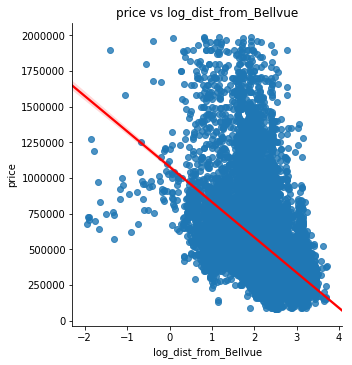

In [75]:
feature_plots('log_dist_from_Bellvue', 'price', smaller_df)

In [9]:
#define a function that will provide a couple plots for a feature - histogram and scatter
def feature_plots(feature,target,df):
    """
    Creates a histogram of the desired feature and a scatter plot of the target vs. the feature.
    feature = feature (column) name.
    target = target (column) name.
    df = dataframe containing both the feature and target
    returns nothing
    """
    #Print feature name to screen
    print(feature)
    
    #Histogram using sns distplot
    plt.title("{} histogram".format(feature))
    sns.distplot(df[feature])
    plt.show()
    
    #Scatter Plot using sns lmplot
    sns.lmplot(x=feature, y=target, data=df, line_kws={'color': 'red'})
    plt.title("{} vs {}".format(target, feature))
    plt.show()
    
    pass